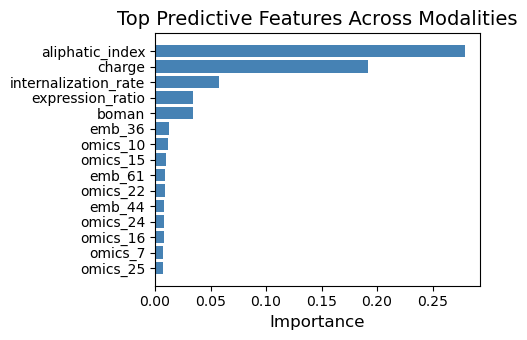

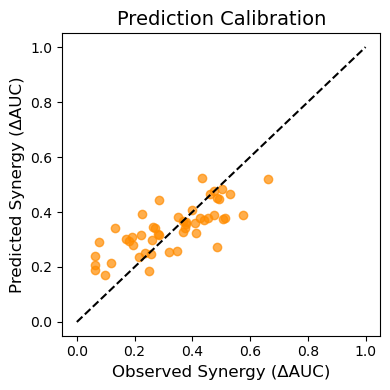

/tmp/ipykernel_2981/778318683.py:160: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, max_display=15, show=True)


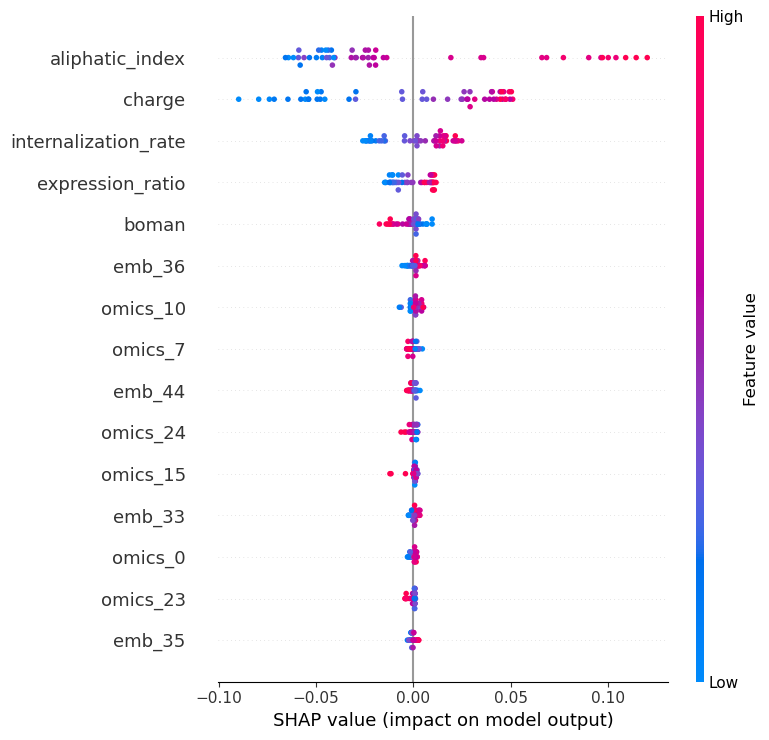

/tmp/ipykernel_2981/778318683.py:162: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15, show=True)


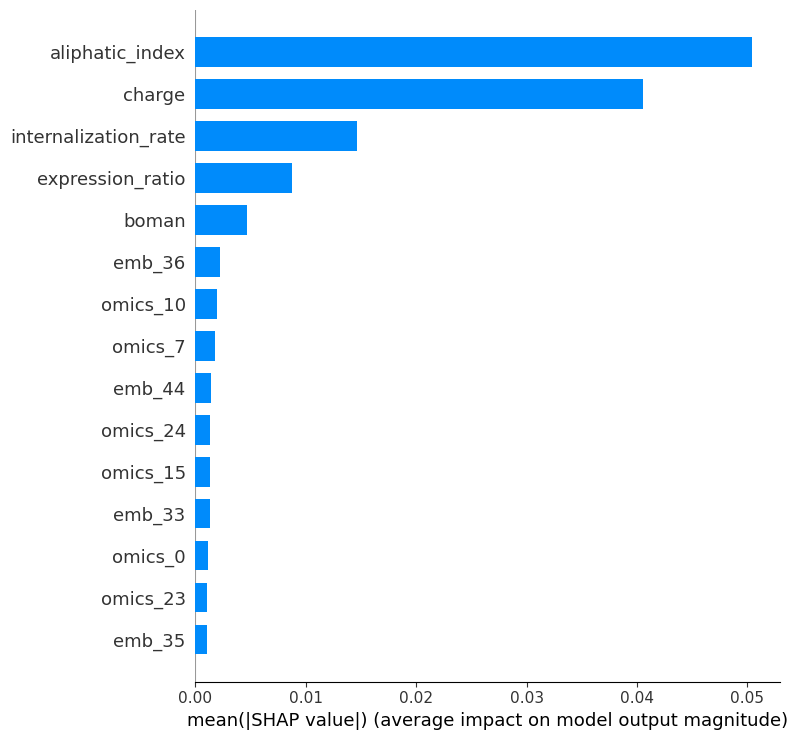

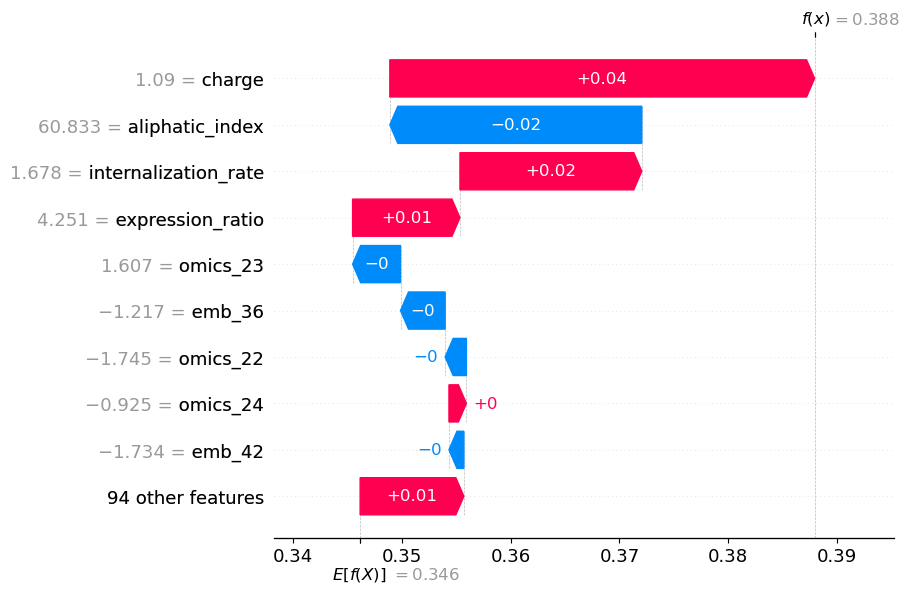

/home/yc/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


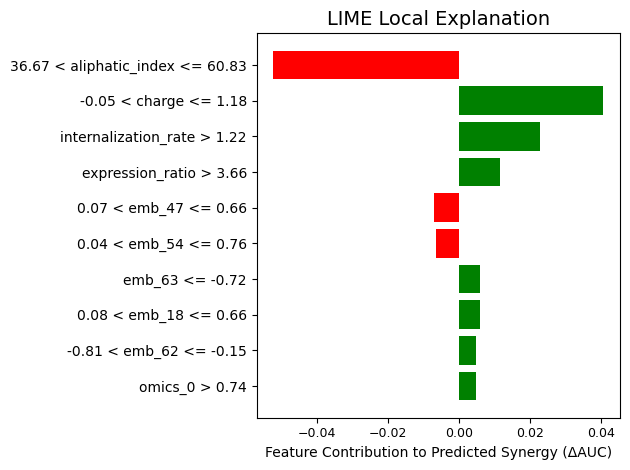

In [7]:
# ============================================================
# BsADC Prediction + Interpretation (SHAP + optional LIME)
# ============================================================

# -----------------------------
# 1. Imports
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peptides
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Optional LIME import
try:
    from lime.lime_tabular import LimeTabularExplainer
    lime_available = True
except ImportError:
    lime_available = False
    print("LIME not installed — skipping LIME explanation.")

np.random.seed(42)

# -----------------------------
# 2. Dataset dimensions
# -----------------------------
n_pairs = 200
n_embeddings = 64
n_omics = 30
AA = list("ACDEFGHIKLMNPQRSTVWY")

# -----------------------------
# 3. Generate bispecific binder sequences
# -----------------------------
def random_peptide(length=12):
    return "".join(np.random.choice(AA, length))

combo = [random_peptide() + random_peptide() for _ in range(n_pairs)]

# -----------------------------
# 4. Physicochemical features
# -----------------------------
def peptide_features(seq):
    p = peptides.Peptide(seq)
    return {
        "length": len(seq),
        "charge": p.charge(pH=7),
        "boman": p.boman(),
        "aliphatic_index": p.aliphatic_index(),
        "instability_index": p.instability_index()
    }

physchem = pd.DataFrame([peptide_features(s) for s in combo])

# -----------------------------
# 5. Sequence embeddings (dummy)
# -----------------------------
seq_embeddings = pd.DataFrame(
    np.random.normal(0, 1, (n_pairs, n_embeddings)),
    columns=[f"emb_{i}" for i in range(n_embeddings)]
)

# -----------------------------
# 6. Cell-line omics
# -----------------------------
omics = pd.DataFrame(
    np.random.normal(0, 1, (n_pairs, n_omics)),
    columns=[f"omics_{i}" for i in range(n_omics)]
)

# -----------------------------
# 7. Lab response data
# -----------------------------
lab = pd.DataFrame({
    "mono_A_auc": np.random.uniform(0.1, 1.0, n_pairs),
    "mono_B_auc": np.random.uniform(0.1, 1.0, n_pairs),
    "internalization_rate": np.random.normal(1, 0.3, n_pairs),
    "expression_ratio": np.random.uniform(0.1, 5.0, n_pairs)
})

# -----------------------------
# 8. Merge features
# -----------------------------
X = pd.concat([physchem, seq_embeddings, omics, lab], axis=1)

# -----------------------------
# 9. Simulate synergy signal
# -----------------------------
y = (
    0.35 * physchem["aliphatic_index"] / physchem["aliphatic_index"].max()
    + 0.25 * physchem["charge"] / physchem["charge"].abs().max()
    + 0.20 * lab["internalization_rate"]
    + 0.15 * lab["expression_ratio"] / lab["expression_ratio"].max()
    - 0.20 * physchem["boman"] / physchem["boman"].abs().max()
    + np.random.normal(0, 0.05, n_pairs)
).clip(0)

# -----------------------------
# 10. Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# -----------------------------
# 11. Train Random Forest
# -----------------------------
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ============================================================
# 12. Global feature importance
# ============================================================
imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(5,3.5))
plt.barh(imp.head(15)["Feature"], imp.head(15)["Importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance", fontsize=12)
plt.title("Top Predictive Features Across Modalities", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# -----------------------------
# Prediction calibration
# -----------------------------
plt.figure(figsize=(4,4))
plt.scatter(y_test, y_pred, alpha=0.7, color="darkorange")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Observed Synergy (ΔAUC)", fontsize=12)
plt.ylabel("Predicted Synergy (ΔAUC)", fontsize=12)
plt.title("Prediction Calibration", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# ============================================================
# 13. SHAP interpretation
# ============================================================

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Global SHAP summary (dot)
shap.summary_plot(shap_values, X_test, max_display=15, show=True)
# Global SHAP bar
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15, show=True)

# Local SHAP waterfall plot
sample_id = 4
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[sample_id],
        base_values=explainer.expected_value,
        data=X_test.iloc[sample_id],
        feature_names=X.columns
    )
)

# ============================================================
# 14. Optional LIME explanation (Matplotlib-friendly)
# ============================================================
if lime_available:
    lime_explainer = LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=X.columns.tolist(),
        mode="regression",
        discretize_continuous=True
    )

    exp = lime_explainer.explain_instance(
        X_test.iloc[sample_id].values,
        model.predict,
        num_features=10
    )

    # Matplotlib-style figure (white background)
    fig = exp.as_pyplot_figure()
    plt.xlabel("Feature Contribution to Predicted Synergy (ΔAUC)", fontsize=10)
    plt.title("LIME Local Explanation", fontsize=14)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=10)
    fig.tight_layout()
    plt.show()

else:
    print("LIME not available — skipped LIME local explanation")

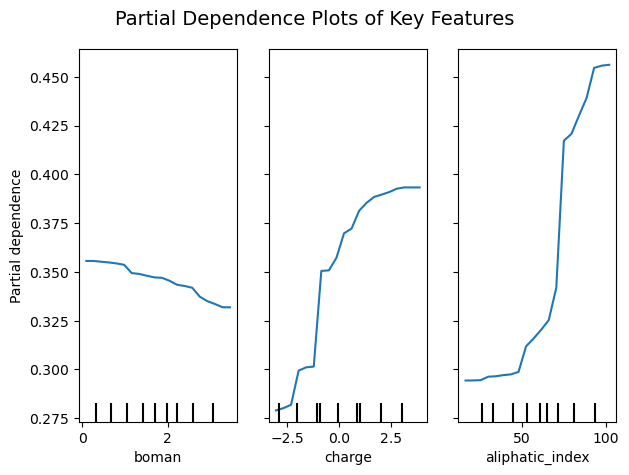

In [9]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ['boman', 'charge', 'aliphatic_index']

PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=features_to_plot,
    grid_resolution=20,
    kind="average"  # average = standard PDP
)
plt.suptitle("Partial Dependence Plots of Key Features", fontsize=14)
plt.tight_layout()
plt.show()

/home/yc/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/yc/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/yc/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/yc/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/yc/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/yc/miniconda3/envs/py311/lib/python3.11

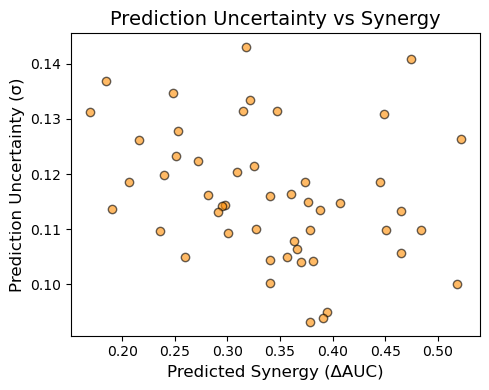

In [10]:
# -----------------------------
# Uncertainty vs Predicted Synergy
# -----------------------------

# Approximate uncertainty from Random Forest: std across trees
all_tree_preds = np.array([tree.predict(X_test) for tree in model.estimators_])
uncertainty = all_tree_preds.std(axis=0)

plt.figure(figsize=(5,4))
plt.scatter(y_pred, uncertainty, c='darkorange', alpha=0.6, edgecolor='k')
plt.xlabel("Predicted Synergy (ΔAUC)", fontsize=12)
plt.ylabel("Prediction Uncertainty (σ)", fontsize=12)
plt.title("Prediction Uncertainty vs Synergy", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()